In [18]:
from keras import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
data = pd.read_csv('data.csv')
data.head()

,UNIXTime,Date,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,2016-09-29,23:55:26,1.21,48,30.46,59,177.39,5.62,0.26,0.76
1,1475229023,2016-09-29,23:50:23,1.21,48,30.46,58,176.78,3.37,0.26,0.76
2,1475228726,2016-09-29,23:45:26,1.23,48,30.46,57,158.75,3.37,0.26,0.76
3,1475228421,2016-09-29,23:40:21,1.21,48,30.46,60,137.71,3.37,0.26,0.76
4,1475228124,2016-09-29,23:35:24,1.17,48,30.46,62,104.95,5.62,0.26,0.76


In [20]:
data_sun = data[['UNIXTime', 'Radiation']].iloc[:31000, :]
data_sun.set_index('UNIXTime', drop = True, inplace = True)
data_sun.tail()

,Radiation
UNIXTime,
1481318139,120.52
1481317850,107.32
1481317540,144.85
1481317251,179.73
1481316953,193.00


In [21]:
MMS = MinMaxScaler()
data_sun[data_sun.columns] = MMS.fit_transform(data_sun)
data_sun.head()

,Radiation
UNIXTime,
1475229326,0.000062
1475229023,0.000062
1475228726,0.000075
1475228421,0.000062
1475228124,0.000037


In [22]:
training_size = round(len(data_sun) * 0.80)
train_data = data_sun[:training_size]
test_data = data_sun[training_size:]

In [23]:
def create_sequence(dataset, sequence_len):
    sequences = []
    labels = []
    start_index = 0
    for stop_index in range(sequence_len, len(dataset)):
        sequences.append(dataset.iloc[start_index : stop_index])
        labels.append(dataset.iloc[stop_index])
        start_index += 1
    return (np.array(sequences), np.array(labels))

In [24]:
X_train, Y_train = create_sequence(train_data, 100)
X_val, Y_val = create_sequence(test_data, 100)
print(X_train.shape, X_val.shape)

(24700, 100, 1) (6100, 100, 1)


In [25]:
from keras import backend 
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [26]:
model = Sequential()
model.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1)) 
model.add(LSTM(units = 32))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mean_absolute_error', rmse])

In [27]:
history = model.fit(X_train, Y_train, epochs = 10, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/10
772/772 [==============================] - 36s 44ms/step - loss: 0.0042 - mean_absolute_error: 0.0330 - rmse: 0.0330 - val_loss: 0.0019 - val_mean_absolute_error: 0.0207 - val_rmse: 0.0207
Epoch 2/10
772/772 [==============================] - 34s 44ms/step - loss: 0.0032 - mean_absolute_error: 0.0275 - rmse: 0.0275 - val_loss: 0.0019 - val_mean_absolute_error: 0.0218 - val_rmse: 0.0218
Epoch 3/10
772/772 [==============================] - 35s 45ms/step - loss: 0.0030 - mean_absolute_error: 0.0258 - rmse: 0.0258 - val_loss: 0.0015 - val_mean_absolute_error: 0.0170 - val_rmse: 0.0170
Epoch 4/10
772/772 [==============================] - 34s 45ms/step - loss: 0.0030 - mean_absolute_error: 0.0254 - rmse: 0.0254 - val_loss: 0.0015 - val_mean_absolute_error: 0.0189 - val_rmse: 0.0189
Epoch 5/10
772/772 [==============================] - 35s 45ms/step - loss: 0.0029 - mean_absolute_error: 0.0240 - rmse: 0.0240 - val_loss: 0.0014 - val_mean_absolute_error: 0.0157 - val_rmse: 0.0157


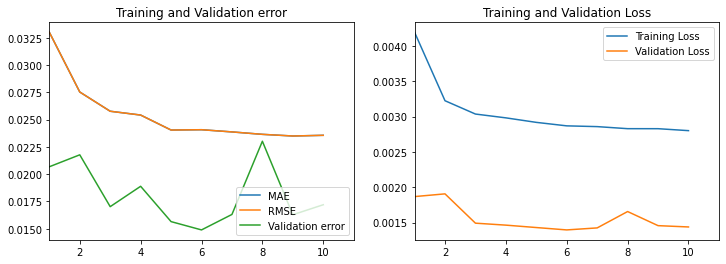

In [28]:
rmse = history.history['rmse']
mae = history.history['mean_absolute_error']
val_error = history.history['val_mean_absolute_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(val_error) + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label = 'MAE')
plt.plot(epochs_range, rmse, label = 'RMSE')
plt.plot(epochs_range, val_error, label = 'Validation error')
plt.legend(loc = 'lower right')
plt.xlim(1, len(val_error) + 1)
plt.title('Training and Validation error')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.xlim(1, len(val_error) + 1)
plt.title('Training and Validation Loss')
plt.show()

In [29]:
print("RMSE values : ",rmse)
print("MAE values : ",mae)

RMSE values :  [0.03300253301858902, 0.027529042214155197, 0.025766246020793915, 0.025418171659111977, 0.02404504269361496, 0.024075251072645187, 0.02387368120253086, 0.023650994524359703, 0.02349943481385708, 0.023561950773000717]
MAE values :  [0.03300253301858902, 0.027529042214155197, 0.025766246020793915, 0.025418171659111977, 0.02404504269361496, 0.024075251072645187, 0.02387368120253086, 0.023650992661714554, 0.02349943481385708, 0.023561952635645866]


In [30]:
test_predicted = model.predict(X_val)

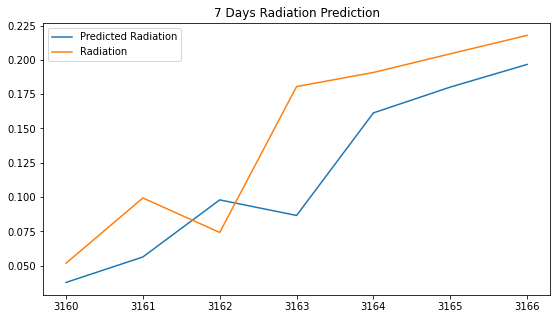

In [31]:
fig = plt.figure(figsize = (20, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(3160, 3167),test_predicted[3160: 3167],label = 'Predicted Radiation')
plt.plot(np.arange(3160, 3167),Y_val[3160: 3167], label = "Radiation")
plt.title('7 Days Radiation Prediction')
plt.legend()

In [32]:
from sklearn.metrics import r2_score
print("Accuracy : ",r2_score(Y_val, test_predicted))

Accuracy :  0.949376712042696
